In [131]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## for processing
import re
import nltk
import w2v_preprocess # Module personnel
import texthero as hero

## for bert language model
import transformers
from sentence_transformers import SentenceTransformer

## for USE language model
import tensorflow as tf
import tensorflow_hub as hub

## for ZERO SHOT learning
from transformers import pipeline

## for clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## for metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

#Module personnel
import helpers

from tqdm.notebook import tqdm
pd.options.display.precision = 4
pd.set_option("display.max_rows", 5000)
pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# <span class="bg-primary">NLP : Modèles de langage BERT et USE, ZERO-SHOT-learning<span>
- __BERT__, acronyme anglais de Bidirectional Encoder Representations from Transformers
- __USE__, acronyme anglais de Universal Sentence Encoder    
# <span class="bg-danger">SOMMAIRE<span>

In [180]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__

- Réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

- Analyser le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering.

__Contraintes:__
    
Mettre en œuvre a minima un __algorithme de type SIFT / ORB / SURF pour  extraire les features__  

# <span class="bg-danger">Pipeline<span>

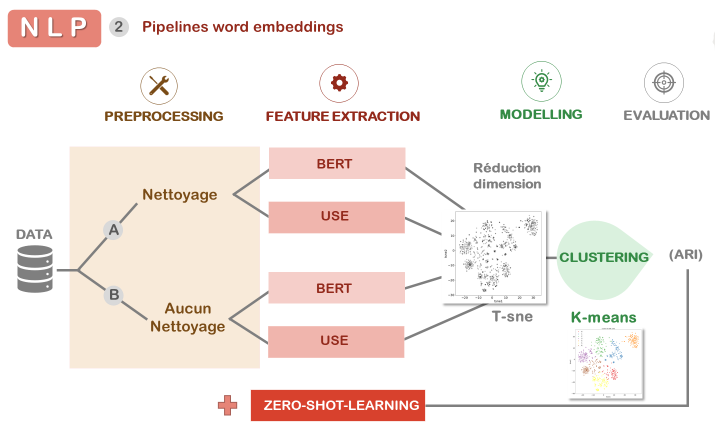

In [181]:
from pyquickhelper.helpgen import NbImage
NbImage("pipeline_BERT_USE_ZERO.png")

## <span class="bg-info"> 1. Chargement et préparation du jeu de données<span>

In [79]:
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df = df[["description", "product_name", "brand", "product_specifications", "product_category_tree"]]
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
del df['product_category_tree']
df.fillna('No', inplace = True)

In [80]:
#liste stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")

#preprocess_text
#Colonne 'product_name'
df["product_name_clean"] = df["product_name"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
#Colonne 'brand'
df["brand_clean"] = df["brand"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=False, 
          lst_stopwords=lst_stopwords))
#Colonne 'product_specifications'
df["product_specifications_clean"] = hero.tokenize(df["product_specifications"])
df["product_specifications_clean"] = df["product_specifications_clean"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
#Colonne 'description'
df["description_clean"] = df["description"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

In [6]:
df.head(2)

description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   

                                        product_name     brand  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  Elegance   
1                         Sathiyas Cotton Bath Towel  Sathiyas   

                              product_specifications            cat_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   

                                  product_name_clean brand_clean  \
0  elegance polyester multicolor abstract eyelet ...    elegance   
1                         sathiyas cotton bath towel    sathiyas   

                        product_specifications_clean  \
0  product _ specification key brand value elegan...   
1  product _ specification key machine washable v...   

                                   description_clean  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel 3 bat...

#### Visualisation du preprocessing

In [7]:
pd.set_option('display.max_colwidth', 800)
df.iloc[0,:].to_frame()

0
description                   Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and wh...
product_name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Elegance Polyester Multicolor Abstract Eyelet Door Curtain
brand                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Elegance
product_specifications                                                                                                                                                                                                                                                                                                                {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}
cat_1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## <span class="bg-info"> 2. Modèle de langage BERT<span>

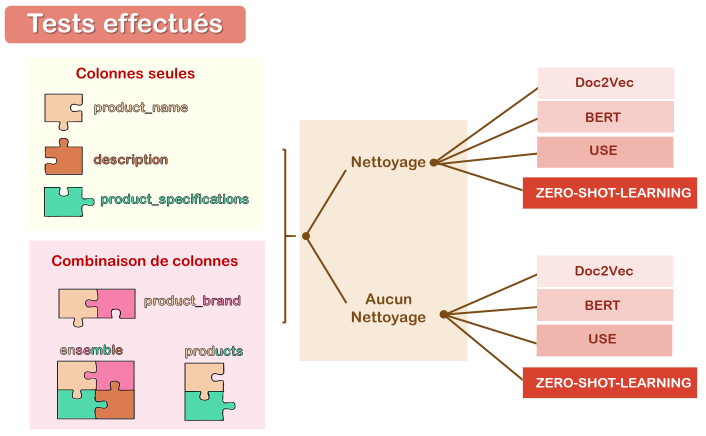

In [1]:
from pyquickhelper.helpgen import NbImage
NbImage("tests_colonnes.png")

### <span class="bg-success"> 2.1 Colonne 'description'<span> 

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


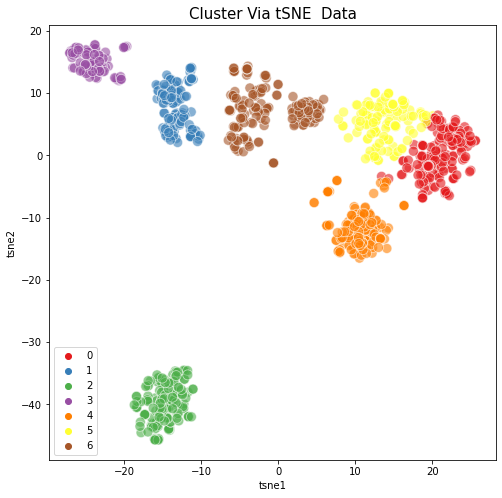

Adjusted Rand Index: 0.278


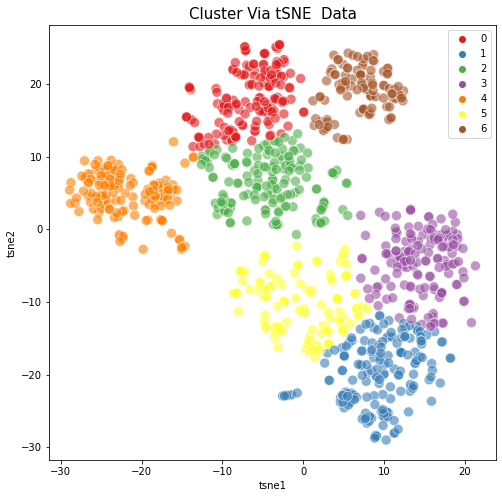

Adjusted Rand Index: 0.357


Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


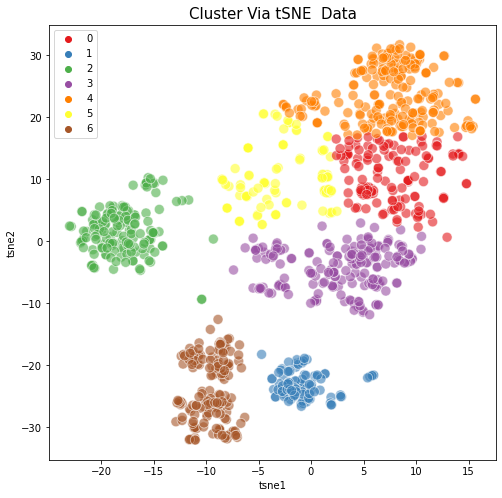

Adjusted Rand Index: 0.371


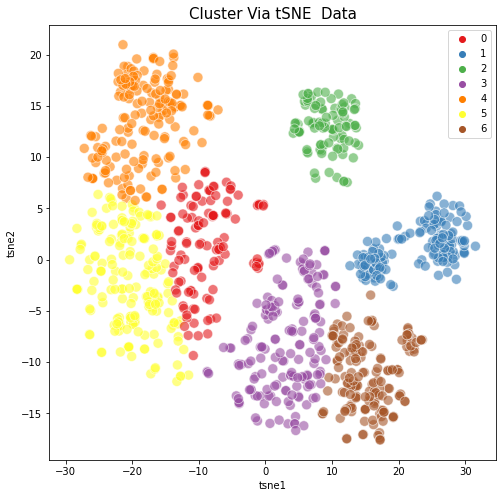

Adjusted Rand Index: 0.349


In [8]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#==================================================== SANS NETTOYAGE ========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== BERT 'roberta-large' ===================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.description
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_D_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_D_R']
from sklearn import metrics
ari_BERT_Roberta_desc = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#====================================== BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.description
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_D_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_D_D']
from sklearn import metrics
ari_BERT_Distillbert_desc = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#================================================ BERT 'roberta-large' =======================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.description_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_DC_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_DC_R']
from sklearn import metrics
ari_BERT_Roberta_desc_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#======================================= BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.description_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_DC_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_DC_D']
from sklearn import metrics
ari_BERT_Distillbert_desc_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [18]:
resultats = pd.DataFrame({
    'Colonne' : ['description', 'description','description','description'],
    'Nettoyage' : ['SANS', 'SANS','AVEC','AVEC'],
    'modèle' : ['BERT_Roberta_large', 'BERT_Distilbert','BERT_Roberta_large', 'BERT_Distilbert'],
    'ARI' : [ari_BERT_Roberta_desc, ari_BERT_Distillbert_desc, ari_BERT_Roberta_desc_clean, ari_BERT_Distillbert_desc_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                           
BERT_Roberta_large  description      SANS  0.2779
BERT_Distilbert     description      SANS  0.3567
BERT_Roberta_large  description      AVEC  0.3710
BERT_Distilbert     description      AVEC  0.3494

### <span class="bg-success"> 2.2 Colonne 'product_name'<span> 

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


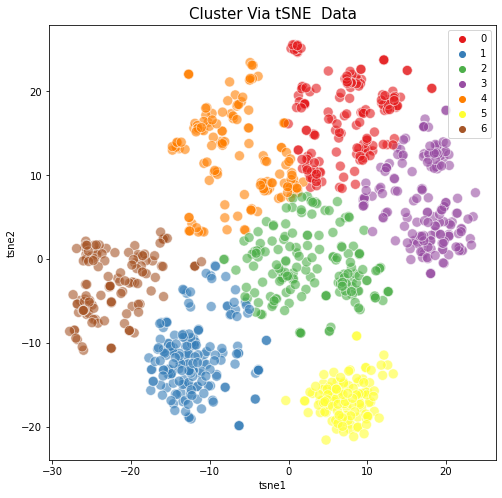

Adjusted Rand Index: 0.444


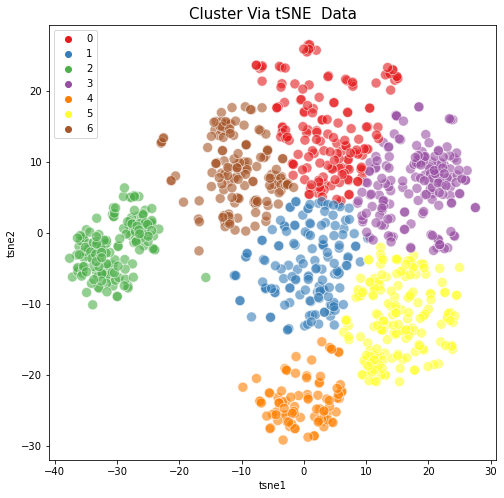

Adjusted Rand Index: 0.477


Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


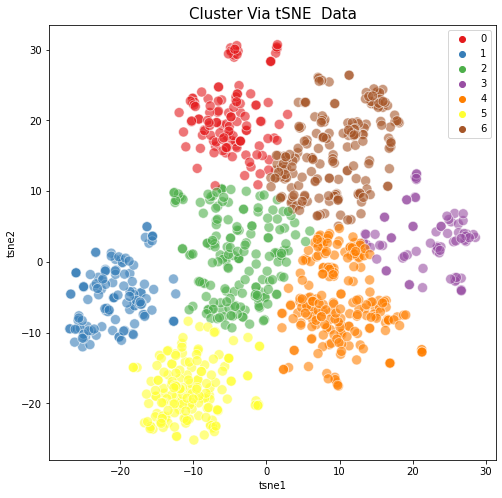

Adjusted Rand Index: 0.497


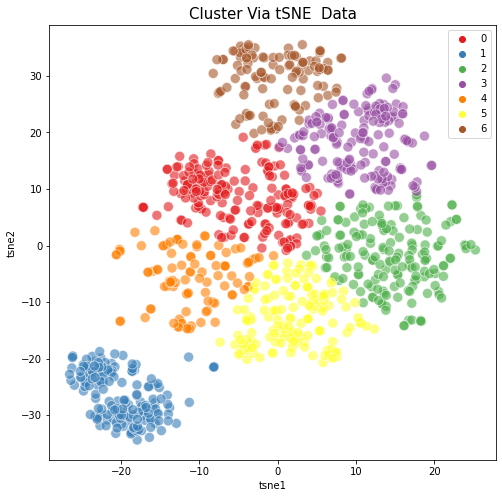

Adjusted Rand Index: 0.488


In [19]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#==================================================== SANS NETTOYAGE ========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== BERT 'roberta-large' ===================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.product_name
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PN_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PN_R']
from sklearn import metrics
ari_BERT_Roberta_pname = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#====================================== BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.product_name
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PN_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PN_D']
from sklearn import metrics
ari_BERT_Distillbert_pname = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#================================================ BERT 'roberta-large' =======================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.product_name_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PNC_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PNC_R']
from sklearn import metrics
ari_BERT_Roberta_pname_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#======================================= BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.product_name_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PNC_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PNC_D']
from sklearn import metrics
ari_BERT_Distillbert_pname_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [25]:
resultats = pd.DataFrame({
    'Colonne' : ['product_name', 'product_name','product_name','product_name'],
    'Nettoyage' : ['SANS', 'SANS','AVEC','AVEC'],
    'modèle' : ['BERT_Roberta_large', 'BERT_Distilbert','BERT_Roberta_large', 'BERT_Distilbert'],
    'ARI' : [ari_BERT_Roberta_pname, ari_BERT_Distillbert_pname, ari_BERT_Roberta_pname_clean, ari_BERT_Distillbert_pname_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                            
BERT_Roberta_large  product_name      SANS  0.4438
BERT_Distilbert     product_name      SANS  0.4767
BERT_Roberta_large  product_name      AVEC  0.4969
BERT_Distilbert     product_name      AVEC  0.4876

### <span class="bg-success"> 2.3 Colonne 'product_specifications'<span> 

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


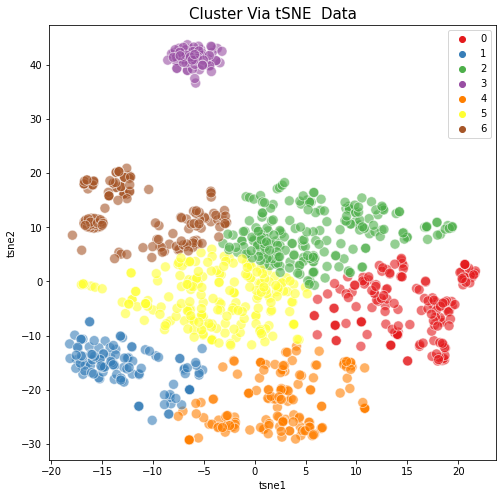

Adjusted Rand Index: 0.344


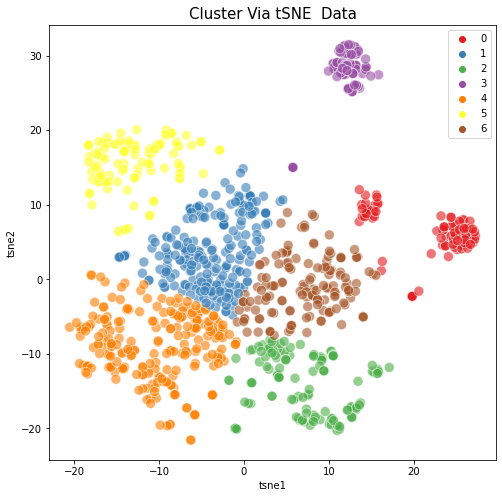

Adjusted Rand Index: 0.426


Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


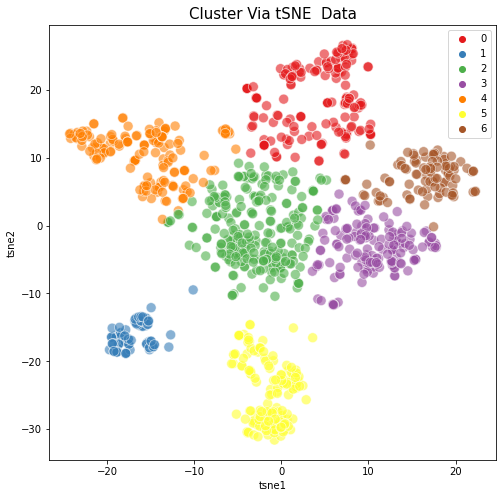

Adjusted Rand Index: 0.586


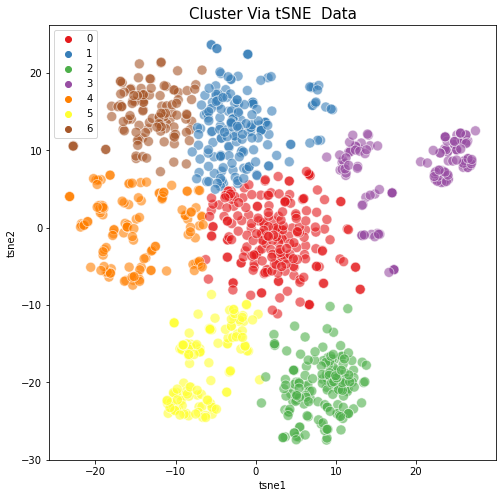

Adjusted Rand Index: 0.564


In [21]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#==================================================== SANS NETTOYAGE ========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== BERT 'roberta-large' ===================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.product_specifications
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PS_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PS_R']
from sklearn import metrics
ari_BERT_Roberta_pspecif = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#====================================== BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.product_specifications
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PS_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PS_D']
from sklearn import metrics
ari_BERT_Distillbert_pspecif = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#================================================ BERT 'roberta-large' =======================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.product_specifications_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PSC_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PSC_R']
from sklearn import metrics
ari_BERT_Roberta_pspecif_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#======================================= BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.product_specifications_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_PSC_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_PSC_D']
from sklearn import metrics
ari_BERT_Distillbert_specif_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [24]:
resultats = pd.DataFrame({
    'Colonne' : ['product_specifications', 'product_specifications','product_specifications','product_specifications'],
    'Nettoyage' : ['SANS', 'SANS','AVEC','AVEC'],
    'modèle' : ['BERT_Roberta_large', 'BERT_Distilbert','BERT_Roberta_large', 'BERT_Distilbert'],
    'ARI' : [ari_BERT_Roberta_pspecif, ari_BERT_Distillbert_pspecif, ari_BERT_Roberta_pspecif_clean, ari_BERT_Distillbert_specif_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                                      
BERT_Roberta_large  product_specifications      SANS  0.3441
BERT_Distilbert     product_specifications      SANS  0.4259
BERT_Roberta_large  product_specifications      AVEC  0.5860
BERT_Distilbert     product_specifications      AVEC  0.5645

### <span class="bg-success"> 2.4 Combinaison de colonnes<span> 

In [41]:
df['products'] = df['product_name'] + " " + df['product_specifications']
df['product_brand']=  df['brand'] + " " + df['product_name']
df['ensemble'] = df['brand'] + " " + df['product_name'] + " " + df['product_specifications'] + " " + df['description']
df['products_clean'] = df['product_name_clean'] + " " + df['product_specifications_clean']
df['product_brand_clean']=  df['brand_clean'] + " " + df['product_name_clean']
df['ensemble_clean'] = df['brand_clean'] + " " + df['product_name_clean'] + " " + df['product_specifications_clean'] + " " + df['description_clean']

#### Visualisation des combinaisons et du preprocessing

In [49]:
pd.set_option('display.max_colwidth', 2100)
df.iloc[1030, 21:28].to_frame()

1030
products                                                                                                                                   OMRD RD6697 Hot and cold Pack {"product_specification"=>[{"key"=>"Re-usable", "value"=>"Yes"}, {"key"=>"Purpose", "value"=>"DRY EYES"}, {"key"=>"Area of Use", "value"=>"Eyes"}]}
products_brand                                                                                                                                                                                                                                                                            OMRD OMRD RD6697 Hot and cold Pack
ensemble              OMRD OMRD RD6697 Hot and cold Pack {"product_specification"=>[{"key"=>"Re-usable", "value"=>"Yes"}, {"key"=>"Purpose", "value"=>"DRY EYES"}, {"key"=>"Area of Use", "value"=>"Eyes"}]} Specifications of OMRD RD6697 Hot and cold Pack (GREEN) General Re-usable Yes Purpose DRY EYES Area of Use Eyes
products_clean                                                                                                                                                                                     omrd rd6697 hot cold pack product _ specification key reusable value yes key purpose value dry eye key area use value eye
products_brand_clean                                                                                                                                                                                                                                                                          omrd omrd rd6697 hot cold pack
ensemble_clean                                                                                omrd omrd rd6697 hot cold pack product _ specification key reusable value yes key purpose value dry eye key area use value eye specification omrd rd6697 hot cold pack green general reusable yes purpose dry eye area use eye
product_brand                                                                                                                                                                                                                                                                             OMRD OMRD RD6697 Hot and cold Pack

In [50]:
pd.set_option('display.max_colwidth', 50)

#### <span class="bg-warning"> 2.4.1 products<span> 

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404


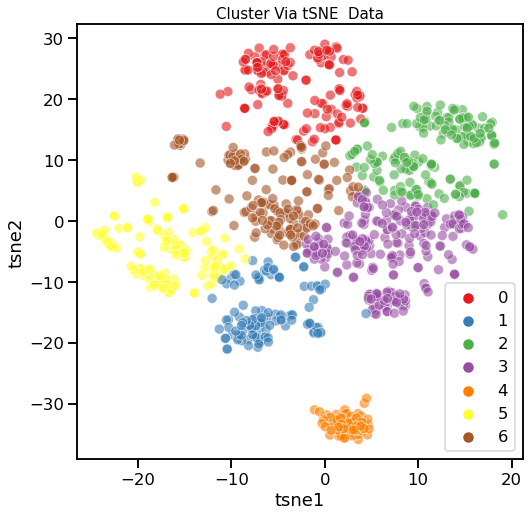

Adjusted Rand Index: 0.412


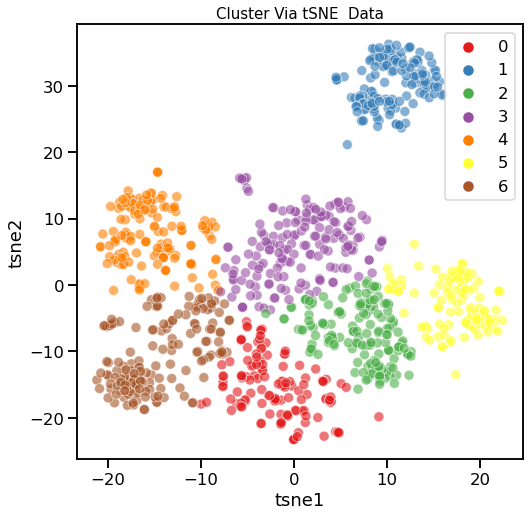

Adjusted Rand Index: 0.623


Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404


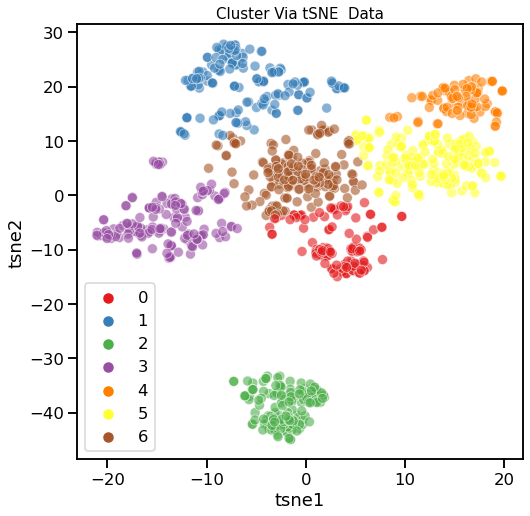

Adjusted Rand Index: 0.678


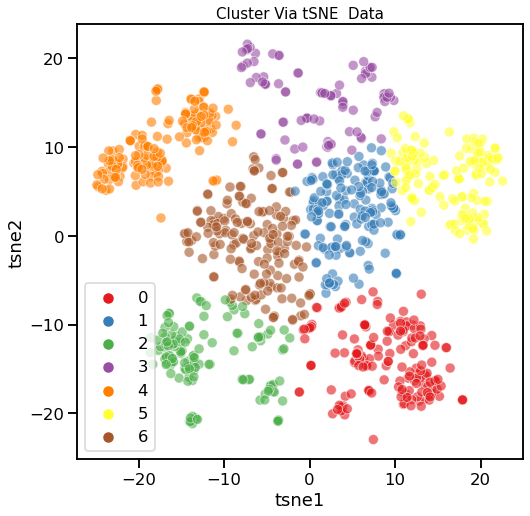

Adjusted Rand Index: 0.598


In [145]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#==================================================== SANS NETTOYAGE ========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== BERT 'roberta-large' ===================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.products
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoP_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoP_R']
from sklearn import metrics
ari_BERT_Roberta_products = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#====================================== BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.products
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoP_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoP_D']
from sklearn import metrics
ari_BERT_Distillbert_products = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#================================================ BERT 'roberta-large' =======================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.products_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoPC_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoPC_R']
from sklearn import metrics
ari_BERT_Roberta_products_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#======================================= BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.products_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoPC_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoPC_D']
from sklearn import metrics
ari_BERT_Distillbert_products_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [149]:
resultats = pd.DataFrame({
    'Colonne' : ['products', 'products','products','products'],
    'Nettoyage' : ['SANS', 'SANS','AVEC','AVEC'],
    'modèle' : ['BERT_Roberta_large', 'BERT_Distilbert','BERT_Roberta_large', 'BERT_Distilbert'],
    'ARI' : [ari_BERT_Roberta_products, ari_BERT_Distillbert_products, ari_BERT_Roberta_products_clean, ari_BERT_Distillbert_products_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                        
BERT_Roberta_large  products      SANS  0.4121
BERT_Distilbert     products      SANS  0.6235
BERT_Roberta_large  products      AVEC  0.6778
BERT_Distilbert     products      AVEC  0.5982

#### Analyse de la classification

In [155]:
df_BERT = df.copy()
df_BERT.groupby('cluster_CoPC_R')['cat_1'].value_counts().to_frame()

cat_1
cluster_CoPC_R cat_1                            
0              Kitchen & Dining              110
               Baby Care                       4
               Beauty and Personal Care        4
               Home Decor & Festive Needs      2
               Computers                       1
1              Beauty and Personal Care      138
               Baby Care                       7
               Watches                         6
               Home Decor & Festive Needs      4
               Computers                       3
               Kitchen & Dining                1
2              Watches                       143
3              Computers                     142
               Home Decor & Festive Needs     12
               Kitchen & Dining               10
               Beauty and Personal Care        3
4              Baby Care                      87
               Beauty and Personal Care        1
               Home Decor & Festive Needs      1
5              Home Furnishing               144
               Baby Care                      35
               Home Decor & Festive Needs     12
               Beauty and Personal Care        1
               Computers                       1
6              Home Decor & Festive Needs    119
               Kitchen & Dining               29
               Baby Care                      17
               Home Furnishing                 6
               Beauty and Personal Care        3
               Computers                       3
               Watches                         1

#### Clusters :
- __0__ : Kitchen & Dining
- __1__ : Beauty and Personal Care
- __2__ : Watches	
- __3__ : Computers
- __4__ : Baby Care
- __5__ : Home Furnishing
- __6__ :Home Decor & Festive Needs

#### Visualisation de la qualité du clustering avec une matrice de confusion

In [113]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_pred.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

In [157]:
df_BERT.head()

description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and wh...   
1                                                                                                                                                                                                                                                                                                                                                                     Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL SET, Assorted) Price: Rs. 299 Eurospa brings to you an exclusively designed, 100% soft cotton towels of export quality. All our products have soft texture that takes care of your skin and gives you that enriched feeling you deserve. Eurospa has been exporting its bath towels to lot of renowned brands for last 10 years and is famous for its fine prints, absorbency, softness and durability. NOTE: Our product is 100% cotton, so it is susceptible to shrinkage. Product color may vary from the picture. Size may vary by ±3% WASH CARE: Wash in cold Water, Do not Iron, Do not Bleach, Flat dry, Wash before first use. SIZE- FACE TOWEL - 23 cms X 23 cms.,...   
3  Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet (1 Bedsheet,2 Pillow Cover, Multicolor) General Brand SANTOSH ROYAL FASHION Machine Washable Yes Type Flat Material Cotton Model Name Gold Design Royal Cotton Printed Wedding & Gifted Double Bedsheet With 2 Pillow cover Model ID goldbedi-38 Color Multicolor Size King Fabric Care Machine Wash, Do Not Bleach Dimensions Flat Sheet Width 90 inch / 230 cm Fitted Sheet Width 228 cm Pillow Cover Width 16 inch / 43 cm Pillow Cover Length 28 inch / 72 cm Fitted Sheet Depth 280 cm Fitted Sheet Length 278 cm Flat Sheet Depth 282 cm Flat Sheet Length 110 inch / 280 cm In the Box Number of Conte...   
4  Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice bed sheet made up of 100% cotton to give you comfort. This bed sheet is hand printed. This bedsheet gives nice look to your room And its fast colour and good quality gives this bedsheet long life.,Specifications of Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) General Machine Washable Yes Brand Jaipur Print Type Flat Model Name jaipur117 Material Cotton Thread Count 140 Model ID jaipur117 Fabric Care machinewash, do not bleach Size King Color White Warranty waranty of the product only for manufacturing defect on


accuracy: 84.1%


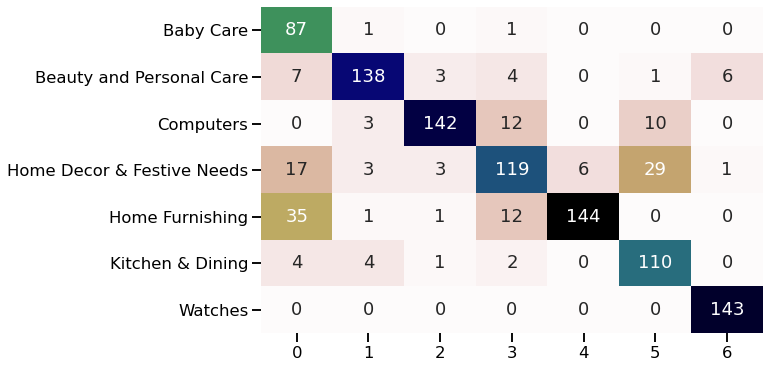

                            precision    recall  f1-score   support

                 Baby Care       0.58      0.98      0.73        89
  Beauty and Personal Care       0.92      0.87      0.89       159
                 Computers       0.95      0.85      0.90       167
Home Decor & Festive Needs       0.79      0.67      0.73       178
           Home Furnishing       0.96      0.75      0.84       193
          Kitchen & Dining       0.73      0.91      0.81       121
                   Watches       0.95      1.00      0.98       143

                  accuracy                           0.84      1050
                 macro avg       0.84      0.86      0.84      1050
              weighted avg       0.86      0.84      0.84      1050



In [158]:
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R']
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(0, 'Kitchen & Dining')
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(1, 'Beauty and Personal Care')
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(2, 'Watches')
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(3, 'Computers')
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(4, 'Baby Care')
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(5, 'Home Furnishing')
df_BERT['cluster_CoPC_R_label'] = df_BERT['cluster_CoPC_R_label'].replace(6, 'Home Decor & Festive Needs')
categories_predict = df_BERT['cluster_CoPC_R_label']
categories_true = df_BERT['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

In [160]:
df_errors_BERT = df_BERT[df['cat_1'] != df_BERT['cluster_CoPC_R_label']]
df_errors_BERT.shape

(167, 22)

In [184]:
pd.set_option('display.max_colwidth', 100)
df_errors_BERT[df_errors_BERT['cat_1'] == 'Baby Care']

description  \
1     Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2     Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   
63    Key Features of KOHL Wine Bag Yellow Easy to carry GiftBags JuteBags Bits&Bobs,Specifications of...   
66    Specifications of CHHOTE JANAB COZY MATTRESS PROTECTOR(SET OF 2) (MULTI) Baby Mattress Features ...   
82    Specifications of CHINMAY KIDS Printed Cotton Padded Mosquito Net (Multicolour) Convenience Feat...   
106   Buy Bestway 1.47m x 1.47m x 1.22m/Play With Sun Shade Inflatable Play Pool for Rs.2499 online. B...   
114   Flipkart.com is offering Lollipop Lane Tiddly Wink Safari Bath Set for only for Rs 2950 | Flipka...   
426   Specifications of BASRA uepgrn Green Changing Table General Brand BASRA Model Number tab-pgrn01 ...   
428   Specifications of Graco LiteRider Click Connect � Marco (Multicolor) General Foldable Yes Age Gr...   
440   Specifications of Baby Bucket SHERIN MULTI BEAR Sleeping Bag (Green) General Brand Baby Bucket S...   
448   Key Features of 3kFactory Baby Shower Cap- Purple Easy Bathing for your kids !! These Caps ensur...   
468   Key Features of Tks Cotton Hair Towel Size: Medium Height: 56 inch GSM: 30 Usage: Daily Use,Spec...   
615   Specifications of Boreal Plastic rectangular hair brush 633D Brush Traits Brush Type Flat brush ...   
622   Mee Mee Multifunctional Nursery Diaper Bag (Dark Blue) Price: Rs. 549 childs safety and health. ...   
651   Buy Marvel Cotton Bath Towel at Rs. 449 at Flipkart.com. Only Genuine Products. Free Shipping. C...   
654   Buy The Intellect Bazaar Cotton Bath Towel, Baby Towel at Rs. 649 at Flipkart.com. Only Genuine ...   
655   Buy Wood Beauty Wood Photo Frame for Rs.450 online. Wood Beauty Wood Photo Frame at best prices ...   
656   Buy BornBabyKids Cotton Bath Towel at Rs. 589 at Flipkart.com. Only Genuine Products. Free Shipp...   
657   Buy Munchkin Mighty Grip Trainer Cup for Rs.349 online. Munchkin Mighty Grip Trainer Cup at best...   
664   Buy Blue Bell Popfun Sipper for Rs.180 online. Blue Bell Popfun Sipper at best prices with FREE ...   
665   Buy Welhouse Cotton Hand & Face Towel Set at Rs. 479 at Flipkart.com. Only Genuine Products. Fre...   
669   Buy Shrikant Traders Cotton Bath Towel at Rs. 1499 at Flipkart.com. Only Genuine Products. Free ...   
670   Buy MH MDF Photo Frame for Rs.899 online. MH MDF Photo Frame at best prices with FREE shipping &...   
672   Indha Craft Cloth Photo Frame (Photo Size - 12.7 X 17.8 cm, 1 Photos)\r\n                       ...   
675   Buy BabyBucket Cotton Bath Towel at Rs. 735 at Flipkart.com. Only Genuine Products. Free Shippin...   
678   Buy Neyth Cotton Set of Towels at Rs. 170 at Flipkart.com. Only Genuine Products. Free Shipping....   
681   Cocovey Metal Photo Frame (Photo Size - 6*4, 1 Photos)\r\n                         Price: Rs. 54...   
709   U & ME Cotton Plastic Diaper Reuseable Pad Small -Blue\r\n                         Price: Rs. 27...   
712   Flipkart.com is offering MyKid Nappy for only for Rs 199 | Flipkart.com. Only Genuine Products. ...   
770   Buy Offspring Solid Single Blanket Pink at Rs. 305 at Flipkart.com. Only Genuine Products. Free ...   
771   Offspring Printed Single Blanket Blue (1 Blanket)\r\n                         Price: Rs. 305\r\n...   
772   Buy Offspring Printed Single Wrapper Multicolor at Rs. 290 at Flipkart.com. Only Genuine Product...   
773   Buy Ireeya Abstract Single Coral Blanket Blue at Rs. 529 at Flipkart.com. Only Genuine Products....   
774   Offspring Embroidered, Solid Single Wrapper White, Pink (1 Wrap)\r\n                         Pri...   
775   Buy Carter'S Self Design Single Blanket Multicolor at Rs. 980 at Flipkart.com. Only Genuine Prod...   
776   Buy My NewBorn Solid Single Wrapper Assorted Muti Colors at Rs. 550 at Flipkart.com. Only Genuin...   
783   Flipkart.com is offering Small Funcart Party Time  - Fo

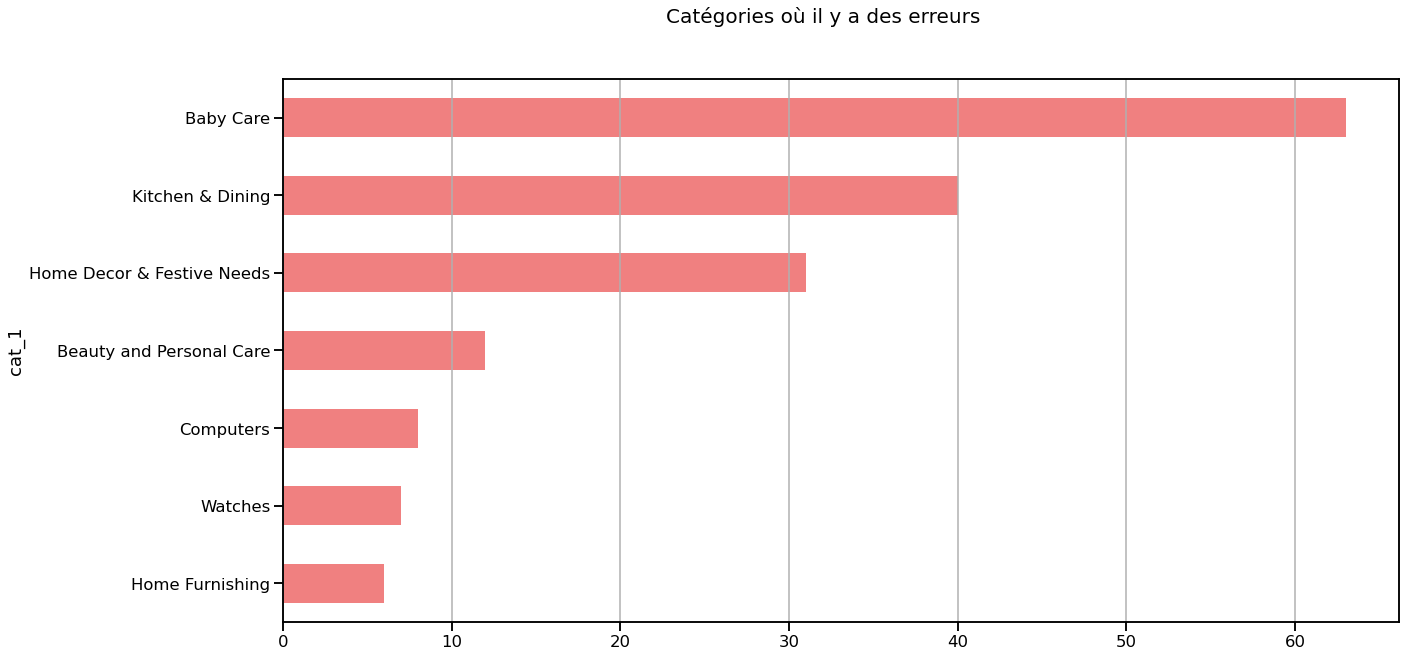

In [161]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Catégories où il y a des erreurs", fontsize=20)
df_errors_BERT["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, color='lightcoral',
        ax=ax).grid(axis='x')
plt.show()

#### Visualisation de la qualité du clustering avec un Sankey diagram


         'Computers',#7   '#FF90A1', 
         'Baby Care', #8  '#EBBAB5',
         'Beauty and Personal Care',#9  '#8FF9FF'
         'Kitchen & Dining ',#10  '#FEF3C7',
         'Watches', #11  '#A6E3D7',
         'Home decor & Festive needs',#12  '#CBB4D5'
         'Home furnishing', #13  '#FFE18F'
          ]
         

color_link = ['#FF90A1',
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#A6E3D7',  
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FFE18F','#FFE18F']


In [178]:
#Sankey vue d'ensemble
source = [0, 0, 0, 0,                 # Kitchen & Dining 
          1, 1, 1, 1, 1, 1,           # Beauty and Personal Care 
          2, 2, 2,                    # Watches
          3, 3, 3, 3, 3,              # Computers
          4, 4, 4, 4, 4,              # Baby care   
          5, 5,                       # Home furnishing  
          6, 6, 6, 6, 6, 6 ]          # Home decor & Festive needs              

target = [7, 8, 10, 13,
          8, 7, 10, 11, 12, 13, 
          9, 8, 13,
          10, 7, 8, 12, 13,
          11, 7, 8, 12, 13,
          12, 13,
          13, 7, 8, 10, 11, 12]         

value = [145, 3, 1, 1,
         138, 4, 3, 1, 1, 3,
         143, 6, 1,
         142, 1, 3, 1, 3,
         87, 4, 7, 35, 17,
         144, 6,
         119, 2, 4, 12, 1, 12]

label = ['Kitchen & Dining',#0
         'Beauty and Personal Care', #1
         'Watches',#2
         'Computers',#3
         'Baby care', #4
         'Home furnishing',#5
         'Home decor & Festive needs', #6
         
         'Kitchen & Dining', #7
         'Beauty and Personal Care', #8
         'Watches',#9
         'Computers',#10
         'Baby care', #11
         'Home furnishing',#12
         'Home decor & Festive needs', #13
          ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',  
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', ]
         
# link data
color_link = ['#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7',
              '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF',  
              '#A6E3D7', '#A6E3D7', '#A6E3D7',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1',
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#FFE18F', '#FFE18F', 
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5']


# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Qualité de la classification, modèle BERT, roberta_large, products",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

#### <span class="bg-warning"> 2.4.2 product_brand<span> 

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


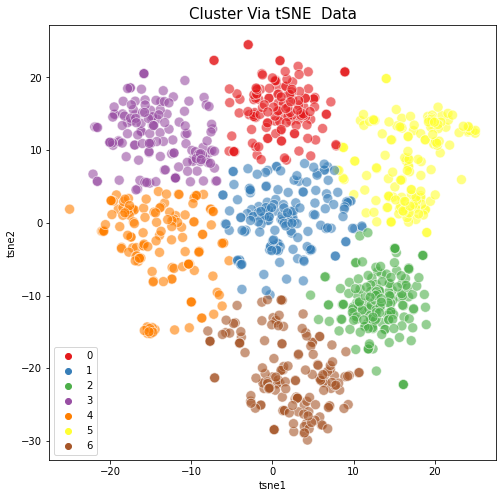

Adjusted Rand Index: 0.551


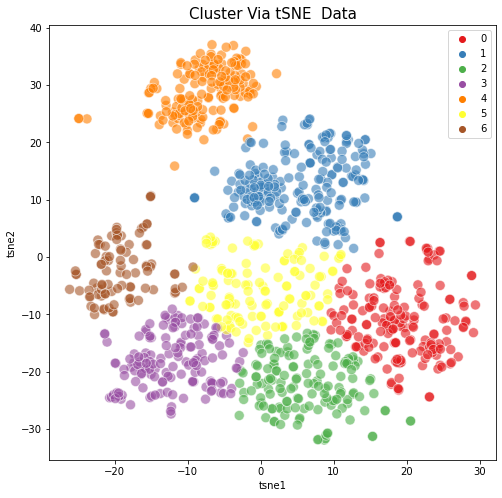

Adjusted Rand Index: 0.452


Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


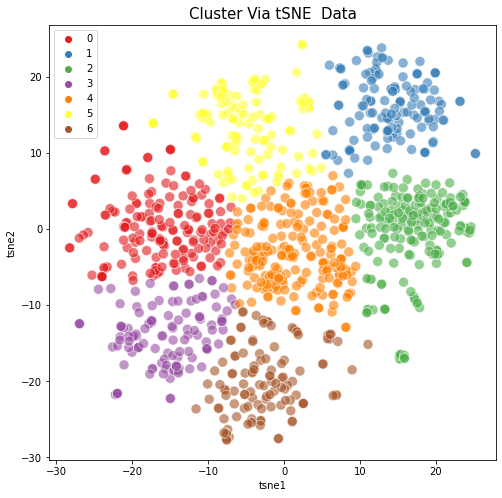

Adjusted Rand Index: 0.443


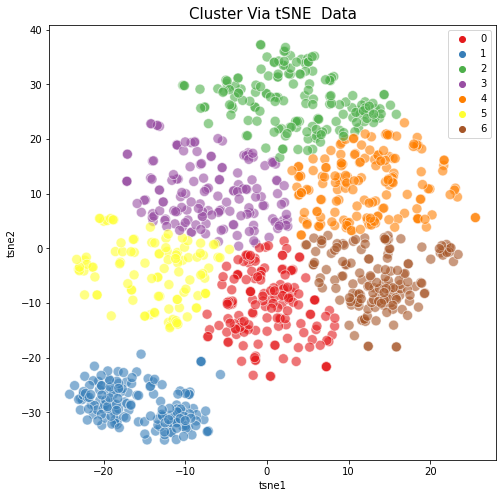

Adjusted Rand Index: 0.430


In [53]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#==================================================== SANS NETTOYAGE ========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== BERT 'roberta-large' ===================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.product_brand
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoPB_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoPB_R']
from sklearn import metrics
ari_BERT_Roberta_product_brand = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#====================================== BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.product_brand
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoPB_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoPB_D']
from sklearn import metrics
ari_BERT_Distillbert_product_brand = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#================================================ BERT 'roberta-large' =======================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.product_brand_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoPBC_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoPBC_R']
from sklearn import metrics
ari_BERT_Roberta_product_brand_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#======================================= BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.product_brand_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoPBC_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoPBC_D']
from sklearn import metrics
ari_BERT_Distillbert_product_brand_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [54]:
resultats = pd.DataFrame({
    'Colonne' : ['product_brand', 'product_brand','product_brand','product_brand'],
    'Nettoyage' : ['SANS', 'SANS','AVEC','AVEC'],
    'modèle' : ['BERT_Roberta_large', 'BERT_Distilbert','BERT_Roberta_large', 'BERT_Distilbert'],
    'ARI' : [ari_BERT_Roberta_product_brand, ari_BERT_Distillbert_product_brand, ari_BERT_Roberta_product_brand_clean, ari_BERT_Distillbert_product_brand_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                             
BERT_Roberta_large  product_brand      SANS  0.5509
BERT_Distilbert     product_brand      SANS  0.4515
BERT_Roberta_large  product_brand      AVEC  0.4431
BERT_Distilbert     product_brand      AVEC  0.4303

#### <span class="bg-warning"> 2.4.3 ensemble<span> 

Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


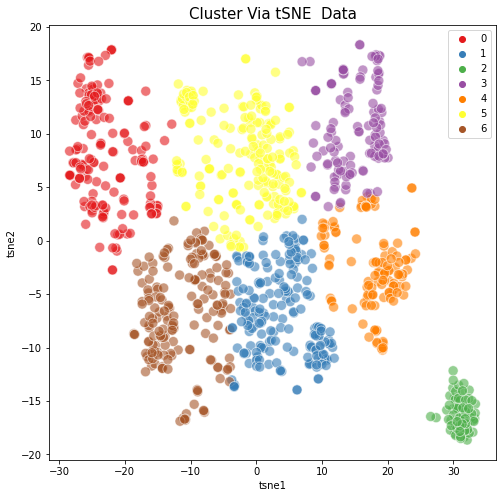

Adjusted Rand Index: 0.426


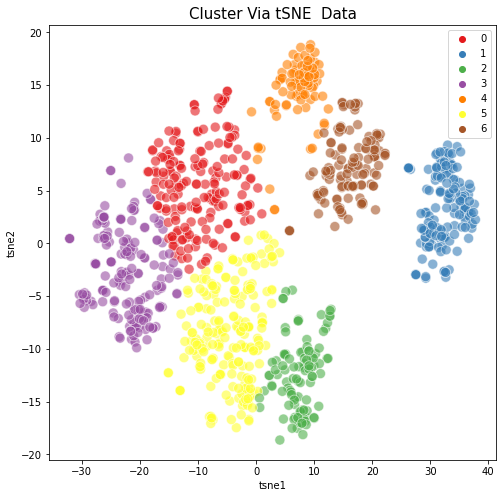

Adjusted Rand Index: 0.596


Exception when trying to download https://sbert.net/models/roberta-large.zip. Response 404
SentenceTransformer-Model https://sbert.net/models/roberta-large.zip not found. Try to create it from scratch
Try to create Transformer Model roberta-large with mean pooling


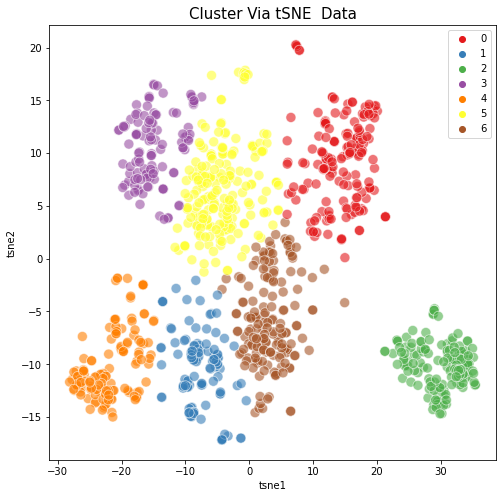

Adjusted Rand Index: 0.589


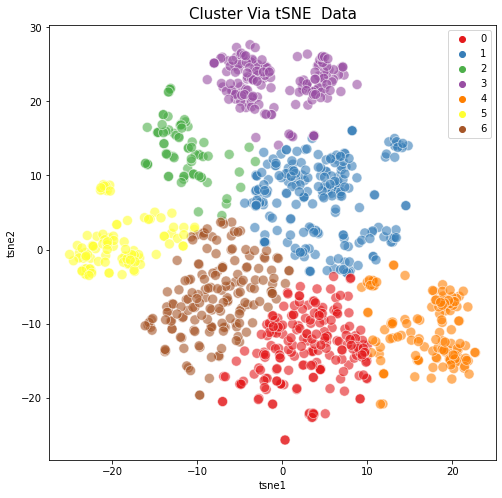

Adjusted Rand Index: 0.544


In [55]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#==================================================== SANS NETTOYAGE ========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== BERT 'roberta-large' ===================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.ensemble
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoE_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoE_R']
from sklearn import metrics
ari_BERT_Roberta_ensemble = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#====================================== BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.ensemble
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoE_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoE_D']
from sklearn import metrics
ari_BERT_Distillbert_ensemble = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#================================================ BERT 'roberta-large' =======================================================


#Modèle 'roberta-large'
model = SentenceTransformer('roberta-large')

#Our sentences we like to encode
sentences = df.ensemble_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoEC_R'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoEC_R']
from sklearn import metrics
ari_BERT_Roberta_ensemble_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


#======================================= BERT 'distilbert-base-nli-stsb-mean-tokens' ==========================================


#Modèle 
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

#Our sentences we like to encode
sentences = df.ensemble_clean
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(embeddings)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_df = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_df = kmeans_tsne_df.labels_
clusters_tsne_df = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_df})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_df.iloc[:,0],clusters_tsne_df.iloc[:,1],hue=labels_tsne_df, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_CoEC_D'] = labels_tsne_df
categories_true = df['cat_1']
categories_predict = df['cluster_CoEC_D']
from sklearn import metrics
ari_BERT_Distillbert_ensemble_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [56]:
resultats = pd.DataFrame({
    'Colonne' : ['ensemble', 'ensemble','ensemble','ensemble'],
    'Nettoyage' : ['SANS', 'SANS','AVEC','AVEC'],
    'modèle' : ['BERT_Roberta_large', 'BERT_Distilbert','BERT_Roberta_large', 'BERT_Distilbert'],
    'ARI' : [ari_BERT_Roberta_ensemble, ari_BERT_Distillbert_ensemble, ari_BERT_Roberta_ensemble_clean, ari_BERT_Distillbert_ensemble_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                        
BERT_Roberta_large  ensemble      SANS  0.4259
BERT_Distilbert     ensemble      SANS  0.5955
BERT_Roberta_large  ensemble      AVEC  0.5886
BERT_Distilbert     ensemble      AVEC  0.5440

## <span class="bg-info"> 3. Modèle de langage USE<span>

In [121]:
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')
df = df[["description", "product_name", "brand", "product_specifications", "product_category_tree"]]
df['cat_1']=df['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
del df['product_category_tree']
df.fillna('No', inplace = True)

In [122]:
#liste stopwords
lst_stopwords = nltk.corpus.stopwords.words("english")

#preprocess_text
#Colonne 'product_name'
df["product_name_clean"] = df["product_name"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
#Colonne 'brand'
df["brand_clean"] = df["brand"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=False, 
          lst_stopwords=lst_stopwords))
#Colonne 'product_specifications'
df["product_specifications_clean"] = hero.tokenize(df["product_specifications"])
df["product_specifications_clean"] = df["product_specifications_clean"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
#Colonne 'description'
df["description_clean"] = df["description"].apply(lambda x: 
          w2v_preprocess.utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

### <span class="bg-success"> 3.1 Colonne 'description'<span> 

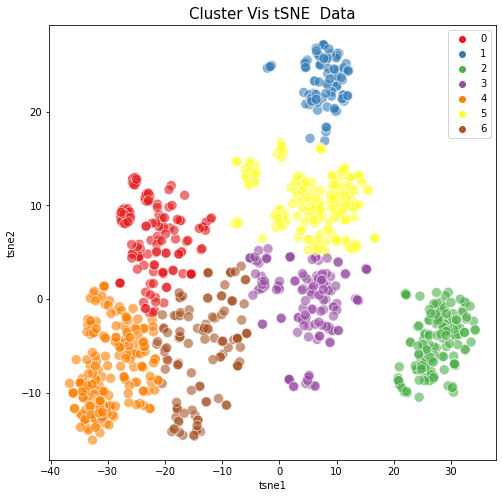

Adjusted Rand Index: 0.390


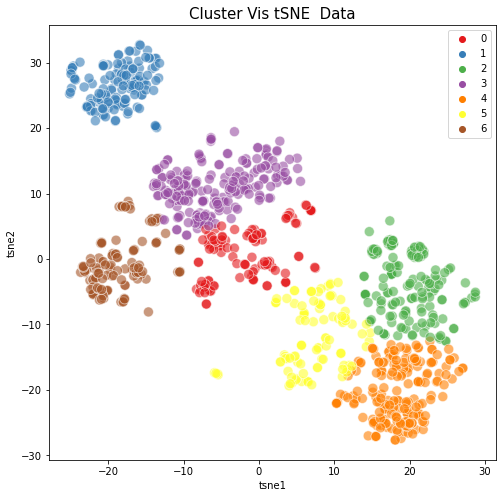

Adjusted Rand Index: 0.396


In [95]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#========================================================= SANS NETTOYAGE ====================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== USE universal-sentence-encoder/4  =======================================


# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['description'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_D'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_D']
ari_USE_desc = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))



#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#=========================================== USE universal-sentence-encoder/4  ===============================================

# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['description_clean'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_DC'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_DC']
ari_USE_desc_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [96]:
resultats = pd.DataFrame({
    'Colonne' : ['description', 'description'],
    'Nettoyage' : ['SANS','AVEC'],
    'modèle' : ['USE/4', 'USE/4'],
    'ARI' : [ari_USE_desc, ari_USE_desc_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                               
USE/4   description      SANS  0.3900
USE/4   description      AVEC  0.3959

### <span class="bg-success"> 3.2 Colonne 'product_name'<span> 

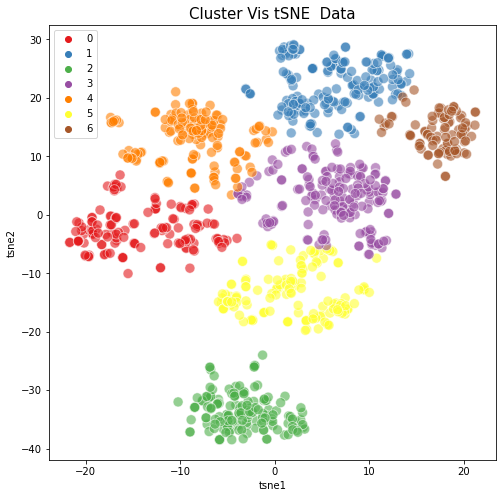

Adjusted Rand Index: 0.650


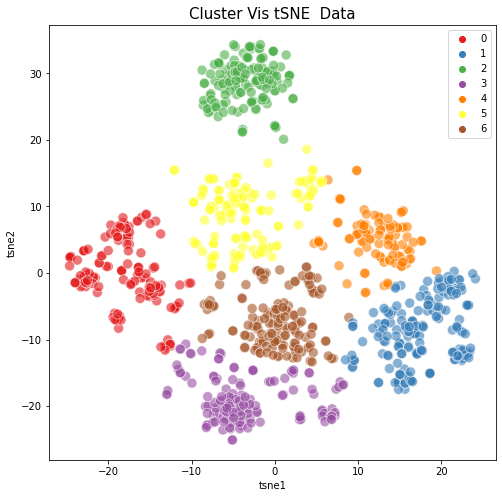

Adjusted Rand Index: 0.619


In [97]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#========================================================= SANS NETTOYAGE ====================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== USE universal-sentence-encoder/4  =======================================


# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['product_name'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PN'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PN']
ari_USE_pname = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))



#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#=========================================== USE universal-sentence-encoder/4  ===============================================

# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['product_name_clean'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PNC'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PNC']
ari_USE_pname_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [98]:
resultats = pd.DataFrame({
    'Colonne' : ['product_name', 'product_name'],
    'Nettoyage' : ['SANS','AVEC'],
    'modèle' : ['USE/4', 'USE/4'],
    'ARI' : [ari_USE_pname, ari_USE_pname_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                
USE/4   product_name      SANS  0.6498
USE/4   product_name      AVEC  0.6193

### <span class="bg-success"> 3.3 Colonne 'product_specifications'<span> 

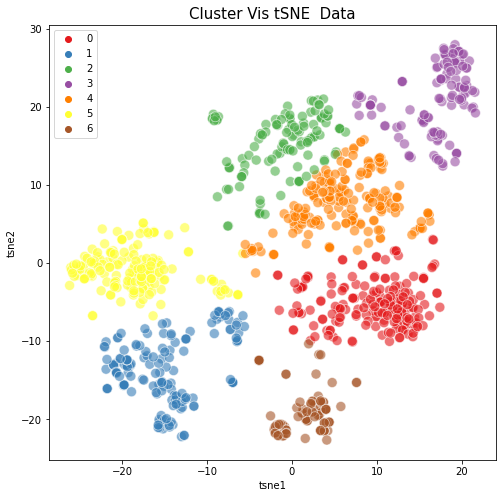

Adjusted Rand Index: 0.557


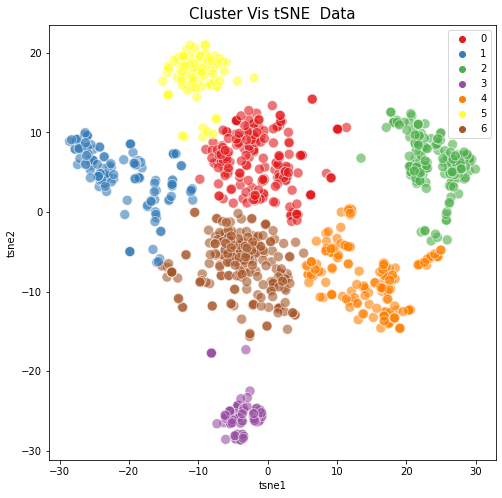

Adjusted Rand Index: 0.625


In [99]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#========================================================= SANS NETTOYAGE ====================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== USE universal-sentence-encoder/4  =======================================


# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['product_specifications'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PS'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PS']
ari_USE_pspecif = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))



#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#=========================================== USE universal-sentence-encoder/4  ===============================================

# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['product_specifications_clean'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PSC'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PSC']
ari_USE_pspecif_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [100]:
resultats = pd.DataFrame({
    'Colonne' : ['product_specifications', 'product_specifications'],
    'Nettoyage' : ['SANS','AVEC'],
    'modèle' : ['USE/4', 'USE/4'],
    'ARI' : [ari_USE_pspecif, ari_USE_pspecif_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                          
USE/4   product_specifications      SANS  0.5572
USE/4   product_specifications      AVEC  0.6249

### <span class="bg-success"> 3.4 Combinaison de colonnes<span> 

In [123]:
df['products'] = df['product_name'] + " " + df['product_specifications']
df['product_brand']=  df['brand'] + " " + df['product_name']
df['ensemble'] = df['brand'] + " " + df['product_name'] + " " + df['product_specifications'] + " " + df['description']
df['products_clean'] = df['product_name_clean'] + " " + df['product_specifications_clean']
df['product_brand_clean']=  df['brand_clean'] + " " + df['product_name_clean']
df['ensemble_clean'] = df['brand_clean'] + " " + df['product_name_clean'] + " " + df['product_specifications_clean'] + " " + df['description_clean']

#### <span class="bg-warning"> 3.4.1 Colonne 'products'<span> 

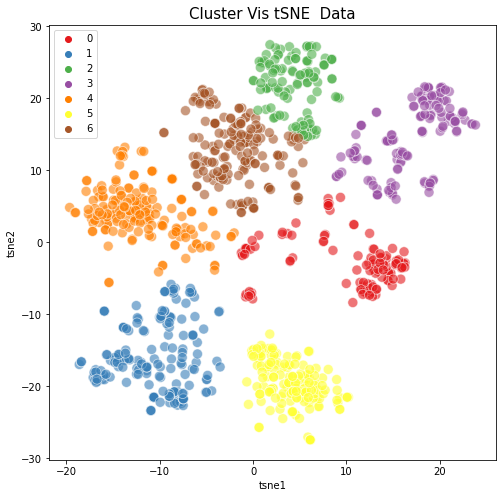

Adjusted Rand Index: 0.652


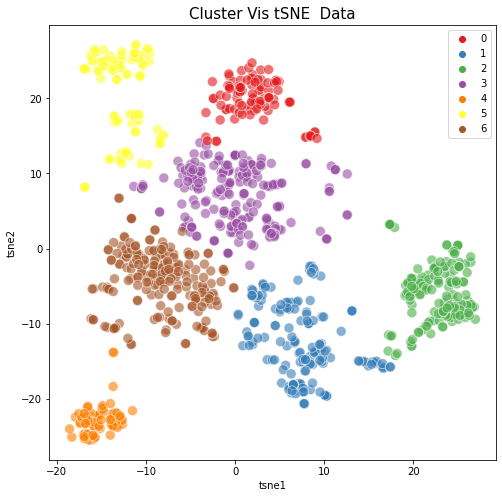

Adjusted Rand Index: 0.605


In [92]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#========================================================= SANS NETTOYAGE ====================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== USE universal-sentence-encoder/4  =======================================


# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['products'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_P'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_P']
ari_USE_products = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))



#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#=========================================== USE universal-sentence-encoder/4  ===============================================

# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['products_clean'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PC'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PC']
ari_USE_products_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [94]:
resultats = pd.DataFrame({
    'Colonne' : ['products', 'products'],
    'Nettoyage' : ['SANS','AVEC'],
    'modèle' : ['USE/4', 'USE/4'],
    'ARI' : [ari_USE_products, ari_USE_products_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                            
USE/4   products      SANS  0.6518
USE/4   products      AVEC  0.6055

#### <span class="bg-warning"> 3.4.2 Colonne 'product_brand'<span> 

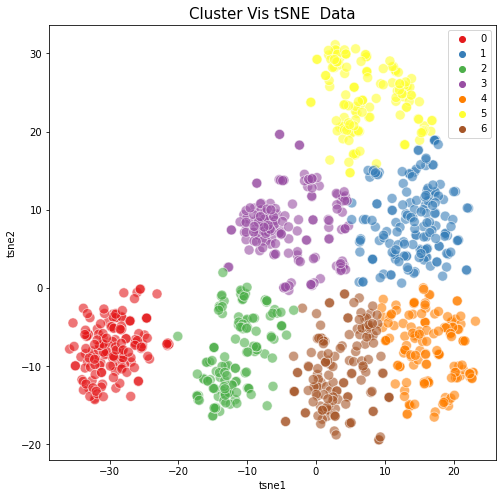

Adjusted Rand Index: 0.625


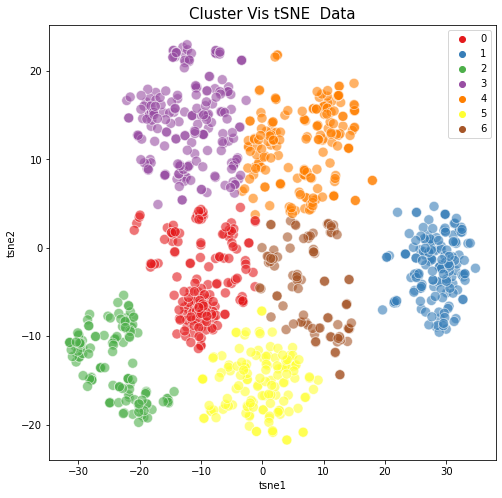

Adjusted Rand Index: 0.557


In [101]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#========================================================= SANS NETTOYAGE ====================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== USE universal-sentence-encoder/4  =======================================


# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['product_brand'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PB'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PB']
ari_USE_pbrand = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))



#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#=========================================== USE universal-sentence-encoder/4  ===============================================

# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['product_brand_clean'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_PBC'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_PBC']
ari_USE_pbrand_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))


In [102]:
resultats = pd.DataFrame({
    'Colonne' : ['product_brand', 'product_brand'],
    'Nettoyage' : ['SANS','AVEC'],
    'modèle' : ['USE/4', 'USE/4'],
    'ARI' : [ari_USE_pbrand, ari_USE_pbrand_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                                 
USE/4   product_brand      SANS  0.6247
USE/4   product_brand      AVEC  0.5568

#### <span class="bg-warning"> 3.4.3 Colonne 'ensemble'<span> 

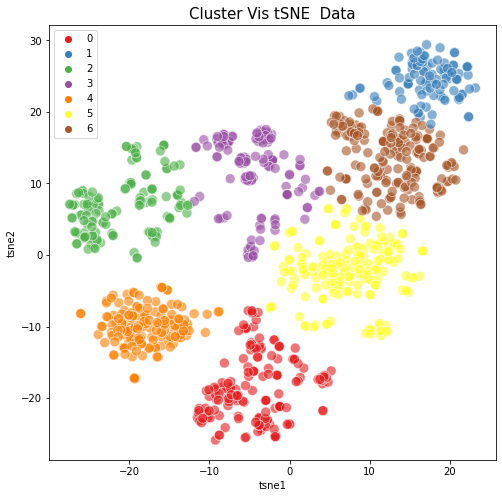

Adjusted Rand Index: 0.730


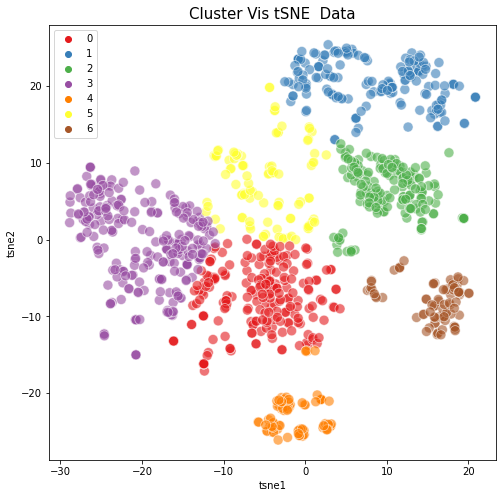

Adjusted Rand Index: 0.507


In [125]:
#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#========================================================= SANS NETTOYAGE ====================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


#=================================================== USE universal-sentence-encoder/4  =======================================


# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['ensemble'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_E'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_E']
ari_USE_ensemble = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))



#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#================================================== AVEC NETTOYAGE ===========================================================

#""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

#=========================================== USE universal-sentence-encoder/4  ===============================================

# get the last version of the encoder from google
encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# encode each description
tf_tensor = encoder(df['ensemble_clean'])

#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne_df_results = tsne.fit_transform(tf_tensor)
tsne_df = pd.DataFrame(tsne_df_results, columns=['tsne1', 'tsne2'])

#Clustering kmeans
kmeans_tsne_USE = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels_tsne_USE = kmeans_tsne_USE.labels_
clusters_tsne_USE = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels_tsne_USE})], axis=1)

#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters_tsne_USE.iloc[:,0],clusters_tsne_USE.iloc[:,1],hue=labels_tsne_USE, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE  Data', fontsize=15)
plt.legend()
plt.show()

#Metrics ARI
df['cluster_USE_EC'] = labels_tsne_USE
categories_true = df['cat_1']
categories_predict = df['cluster_USE_EC']
ari_USE_ensemble_clean = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

In [126]:
resultats = pd.DataFrame({
    'Colonne' : ['ensemble', 'ensemble'],
    'Nettoyage' : ['SANS','AVEC'],
    'modèle' : ['USE/4', 'USE/4'],
    'ARI' : [ari_USE_ensemble, ari_USE_ensemble_clean]})
resultats.set_index('modèle')

Colonne Nettoyage     ARI
modèle                            
USE/4   ensemble      SANS  0.7305
USE/4   ensemble      AVEC  0.5070

#### Analyse de la classification

In [128]:
df_use = df.copy()
df_use.groupby('cluster_USE_E')['cat_1'].value_counts().to_frame()

cat_1
cluster_USE_E cat_1                            
0             Computers                     150
              Home Decor & Festive Needs      7
              Kitchen & Dining                7
              Beauty and Personal Care        2
1             Baby Care                      95
              Home Furnishing                 3
              Beauty and Personal Care        2
2             Beauty and Personal Care      130
              Baby Care                       3
              Home Decor & Festive Needs      1
3             Kitchen & Dining              117
              Home Decor & Festive Needs      5
              Baby Care                       4
              Beauty and Personal Care        1
4             Watches                       150
              Home Decor & Festive Needs      2
              Beauty and Personal Care        1
5             Home Decor & Festive Needs    124
              Kitchen & Dining               24
              Baby Care                      18
              Beauty and Personal Care       10
6             Home Furnishing               147
              Baby Care                      30
              Home Decor & Festive Needs     11
              Beauty and Personal Care        4
              Kitchen & Dining                2

#### Clusters :
- __0__ : Computers
- __1__ : Baby Care
- __2__ : Beauty and Personal Care	
- __3__ : Kitchen & Dining
- __4__ : Watches	
- __5__ : Home Decor & Festive Needs
- __6__ : Home Furnishing

#### Visualisation de la qualité de la classification avec une matrice de confusion


accuracy: 86.95%


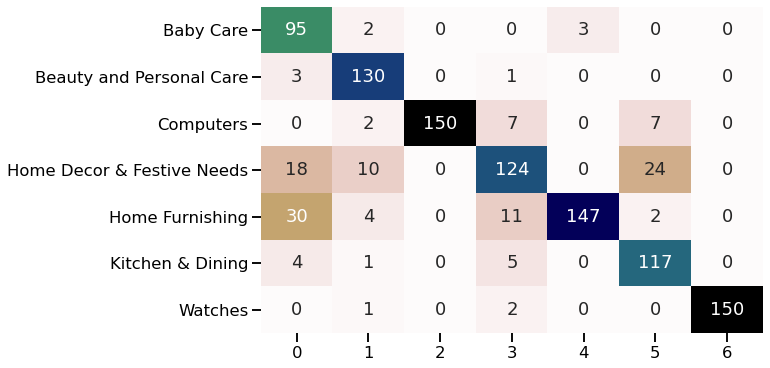

                            precision    recall  f1-score   support

                 Baby Care       0.63      0.95      0.76       100
  Beauty and Personal Care       0.87      0.97      0.92       134
                 Computers       1.00      0.90      0.95       166
Home Decor & Festive Needs       0.83      0.70      0.76       176
           Home Furnishing       0.98      0.76      0.85       194
          Kitchen & Dining       0.78      0.92      0.84       127
                   Watches       1.00      0.98      0.99       153

                  accuracy                           0.87      1050
                 macro avg       0.87      0.88      0.87      1050
              weighted avg       0.89      0.87      0.87      1050



In [132]:
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E']
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(0, 'Computers')
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(1, 'Baby Care')
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(2, 'Beauty and Personal Care')
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(3, 'Kitchen & Dining')
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(4, 'Watches')
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(5, 'Home Decor & Festive Needs')
df_use['cluster_USE_E_label'] = df_use['cluster_USE_E_label'].replace(6, 'Home Furnishing')
categories_predict = df_use['cluster_USE_E_label']
categories_true = df_use['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

In [176]:
df_errors_USE = df_use[df['cat_1'] != df_use['cluster_USE_E_label']]
df_errors_USE.shape

(137, 18)

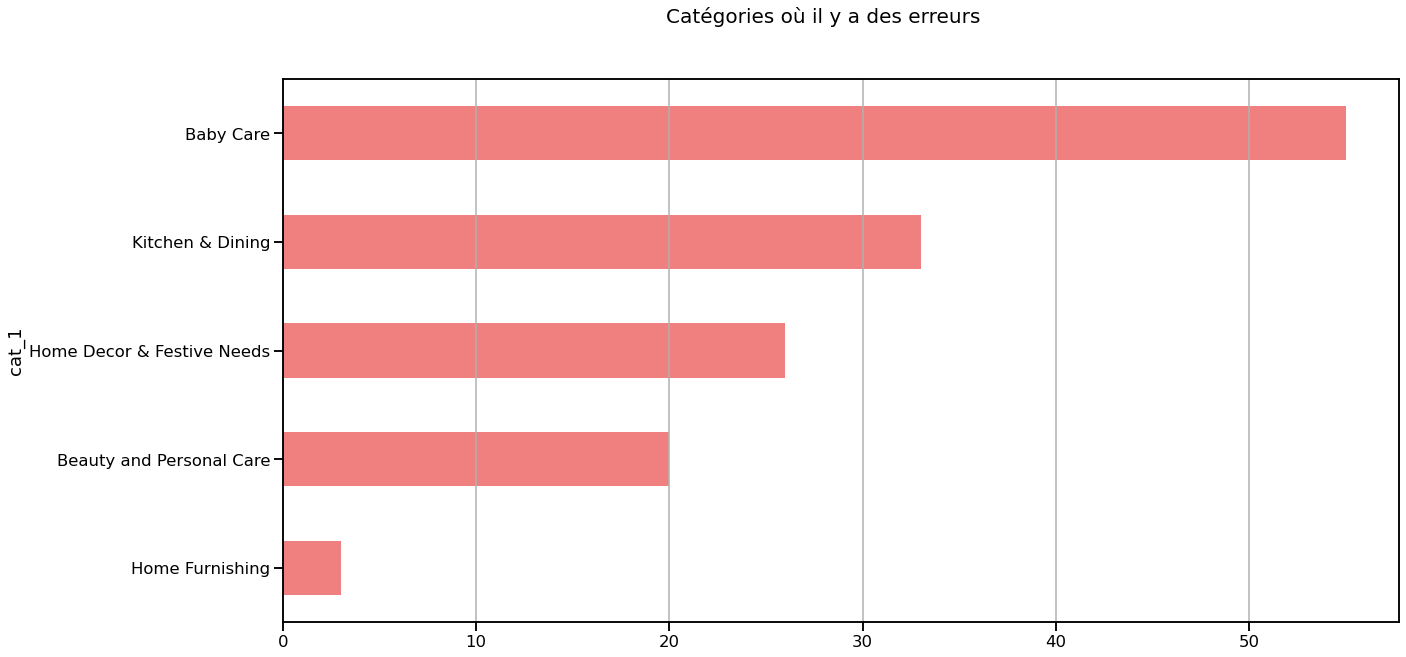

In [177]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Catégories où il y a des erreurs", fontsize=20)
df_errors_USE["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, color='lightcoral',
        ax=ax).grid(axis='x')
plt.show()

#### Visualisation de la qualité de la classification avec un Sankey diagram

In [134]:
#Sankey vue d'ensemble
source = [0,                          # Computers
          1, 1, 1, 1, 1,              # Baby Care   
          2, 2, 2, 2, 2, 2, 2,        # Beauty and Personal Care
          3, 3, 3, 3,                 # Kitchen & Dining 
          4,                          # Watches
          5, 5, 5, 5, 5, 5,           # Home decor & Festive needs
          6, 6]                       # Home furnishing                

target = [7, 
          8, 9 , 10, 12, 13, 
          9, 7, 8, 10, 11, 12, 13,
          10, 7, 12, 13,
          11, 
          12, 7, 9, 10, 11, 13,
          13, 8]         

value = [150,
         95, 3, 4, 18, 30, 
         130, 2, 2, 1, 1, 10, 4,
         117, 7, 24, 2,
         150, 
         124, 7, 1, 5, 2, 11,
         147, 3]

label = ['Computers',#0
         'Baby Care', #1
         'Beauty and Personal Care',#2
         'Kitchen & Dining ',#3
         'Watches', #4
         'Home decor & Festive needs',#5
         'Home furnishing ', #6
         
         'Computers',#7
         'Baby Care', #8
         'Beauty and Personal Care',#9
         'Kitchen & Dining ',#10
         'Watches', #11
         'Home decor & Festive needs',#12
         'Home furnishing', #13
          ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',  
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', ]
         
# link data
color_link = ['#FF90A1',
              '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', 
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#A6E3D7',  
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FFE18F','#FFE18F']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Qualité de la classification, modèle USE/4, ensemble",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

## <span class="bg-info"> 4. Zero-Shot-Learning<span>

### <span class="bg-success"> 4.1 Essai sur une ligne de la colonne product_name<span> 

In [121]:
# Import library
from transformers import pipeline

#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
input_text = ['Elegance Polyester Multicolor Abstract Eyelet Door Curtain']
candidate_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']

#Run classifier
classifier(input_text, candidate_labels, multi_class = True)

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m

{'sequence': 'Elegance Polyester Multicolor Abstract Eyelet Door Curtain',
 'labels': ['Home Furnishing',
  'Home Decor & Festive Needs',
  'Kitchen & Dining',
  'Beauty and Personal Care',
  'Baby Care',
  'Computers',
  'Watches'],
 'scores': [0.9403238892555237,
  0.5285592675209045,
  0.2199157327413559,
  0.09060291200876236,
  0.004732364322990179,
  0.00036295890458859503,
  0.00028281091363169253]}

### <span class="bg-success"> 4.2 Essai sur la colonne product_name<span> 

In [6]:
df_eval_pname = df.filter(items = ['cat_1', 'product_name'])

In [18]:
#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
candidate_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']

#Run classifier
predictions = []
for i in tqdm(range(0,1050)):
    preds = classifier(df_eval_pname['product_name'][i], candidate_labels, multi_class = True)
    pred_labels = preds["labels"][np.argmax(preds["scores"])]
    predictions.append(pred_labels)

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m

In [21]:
predictions;

In [20]:
df_eval_pname['labels_zero_shot'] = predictions

In [22]:
df_eval_pname.head()

cat_1                                       product_name  \
0  Home Furnishing  Elegance Polyester Multicolor Abstract Eyelet ...   
1        Baby Care                         Sathiyas Cotton Bath Towel   
2        Baby Care                Eurospa Cotton Terry Face Towel Set   
3  Home Furnishing  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Home Furnishing  Jaipur Print Cotton Floral King sized Double B...   

           labels_zero_shot  
0           Home Furnishing  
1  Beauty and Personal Care  
2  Beauty and Personal Care  
3           Home Furnishing  
4           Home Furnishing

In [24]:
categories_true = df_eval_pname['cat_1']
categories_predict = df_eval_pname['labels_zero_shot']
ari_USE_zero_shot  = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Adjusted Rand Index: 0.392


In [26]:
df_eval_pname.groupby('labels_zero_shot')['cat_1'].value_counts().to_frame();

### <span class="bg-success"> 4.3 Essai sur la colonne products<span> 

In [146]:
df_eval_products_zero = df.filter(items = ['cat_1', 'products_clean'])

In [116]:
df_eval_products_zero.head()

cat_1  \
0  Home Furnishing   
1        Baby Care   
2        Baby Care   
3  Home Furnishing   
4  Home Furnishing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    products_clean  
0                                                                                                                                                                                                                                                                                                                                                                                                                   elegance polyester multicolor abstract eyelet door curtain product _ specification key brand value elegance key designed value door key type value eyelet key model name value abstract polyester door curtain set 2 key model id value duster25 key color value multicolor key length value 213 cm key number content sale package value pack 2 key sale package value 2 curtain key material value polyester  
1                                                                                                                                                                                                                                                                                                                 sathiyas cotton bath towel product _ specification key machine washable value yes key material value cotton key design value self design key brand value sathiyas key type value bath towel key gsm value 500 key model name value sathiyas cotton bath towel key ideal value men woman boy girl key model id value asvtwl322 key color value red yellow blue key size value mediam key length value 30 inch key width value 60 inch key number content sale package value 3 key sale package value 3 bath towel  
2                                                                                                                                                                                                                                                                                               eurospa cotton terry face towel set product _ specification key material value cotton terry key design value shuvam key brand value eurospa key gsm value 360 key type value face towel set key model name value shuvam20pcftsetassorted key ideal value boy girl men woman key model id value shuvam20pcftsetassorted key size value small key color value assorted key weight value 350 g key length value 9 inch key width value 9 inch key number content sale package value 20 key sale package value 20 piece face towel set  
3  santosh royal fashion cotton printed king sized double bedsheet product _ specification key brand value santosh royal fashion key machine washable value yes key type value flat key material value cotton key model name value gold design royal cotton printed wedding gifted double bedsheet 2 pillow cover key model id value goldbedi38 key color value multicolor key size value king key fabric care value machine wash bleach key flat sheet width value 90 inch 230 cm key fitted sheet width value 228 cm key pillow cover width value 16 inch 43 cm key pillow cover length value 28 inch 72 cm key fitted sheet depth value 280 cm key fitted sheet length value 278 

In [147]:
#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
candidate_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']

#Run classifier
predictions = []
for i in tqdm(range(0,1050)):
    preds = classifier(df_eval_products_zero['products_clean'][i], candidate_labels, multi_class = True)
    pred_labels = preds["labels"][np.argmax(preds["scores"])]
    predictions.append(pred_labels)

#Put results into df    
df_eval_products_zero['labels_zero_shot'] = predictions 

#Metrics ARI
categories_true = df_eval_products_zero['cat_1']
categories_predict = df_eval_products_zero['labels_zero_shot']
ari_USE_zero_shot  = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m


Adjusted Rand Index: 0.570


#### Analyse de la classification effectuée

In [168]:
df_eval_products_zero.groupby('labels_zero_shot')['cat_1'].value_counts().to_frame()

cat_1
labels_zero_shot           cat_1                            
Baby Care                  Baby Care                      78
                           Home Furnishing                 5
                           Computers                       1
                           Home Decor & Festive Needs      1
Beauty and Personal Care   Beauty and Personal Care      136
                           Baby Care                      15
                           Kitchen & Dining               13
                           Home Furnishing                12
                           Computers                       3
                           Home Decor & Festive Needs      3
Computers                  Computers                     127
                           Beauty and Personal Care        1
                           Home Decor & Festive Needs      1
Home Decor & Festive Needs Home Decor & Festive Needs    129
                           Baby Care                      44
                           Home Furnishing                33
                           Kitchen & Dining               21
                           Computers                      16
                           Beauty and Personal Care        7
                           Watches                         1
Home Furnishing            Home Furnishing                91
                           Home Decor & Festive Needs     13
                           Baby Care                       6
                           Beauty and Personal Care        3
                           Computers                       1
                           Kitchen & Dining                1
Kitchen & Dining           Kitchen & Dining              115
                           Home Furnishing                 9
                           Baby Care                       7
                           Computers                       2
                           Home Decor & Festive Needs      2
                           Beauty and Personal Care        1
Watches                    Watches                       149
                           Beauty and Personal Care        2
                           Home Decor & Festive Needs      1

#### Clusters :
- __0__ : Baby Care
- __1__ : Beauty and Personal Care
- __2__ : Computers	
- __3__ : Home Decor & Festive Needs
- __4__ : Home Furnishing
- __5__ : Kitchen & Dining
- __6__ : Watches

#### Visualisation de la qualité de la classification grâce à une matrice de confusion

In [170]:
df_eval_products_zero.head();


accuracy: 78.57%


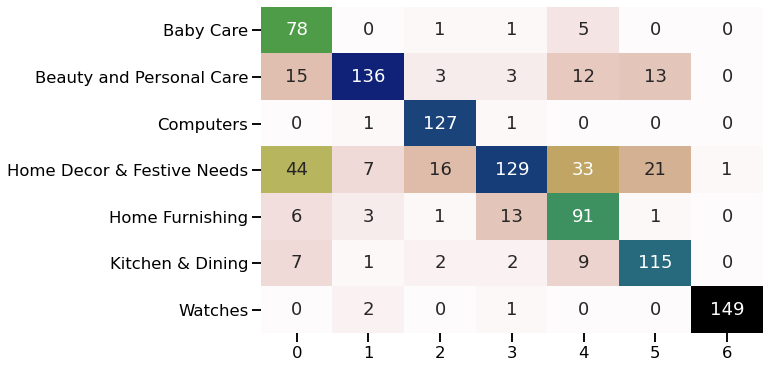

                            precision    recall  f1-score   support

                 Baby Care       0.52      0.92      0.66        85
  Beauty and Personal Care       0.91      0.75      0.82       182
                 Computers       0.85      0.98      0.91       129
Home Decor & Festive Needs       0.86      0.51      0.64       251
           Home Furnishing       0.61      0.79      0.69       115
          Kitchen & Dining       0.77      0.85      0.80       136
                   Watches       0.99      0.98      0.99       152

                  accuracy                           0.79      1050
                 macro avg       0.79      0.83      0.79      1050
              weighted avg       0.82      0.79      0.78      1050



In [171]:
categories_predict = df_eval_products_zero['labels_zero_shot']
categories_true = df_eval_products_zero['cat_1']
print('\naccuracy: {}%'.format(round(accuracy_score(categories_predict,categories_true)*100,2)))
heatconmat(categories_predict,categories_true)

#### Visualisation de la qualité de la classification grâce à un sankey diagram

In [172]:
#Sankey vue d'ensemble
source = [0, 0, 0, 0, 0,              # Baby Care
          1, 1, 1, 1, 1, 1,           # Beauty and Personal Care   
          2, 2, 2, 2, 2, 2,           # Computers  
          3, 3, 3, 3, 3, 3, 3,        # Home decor & Festive needs  
          4, 4, 4, 4, 4,              # Home furnishing 
          5, 5, 5, 5,                 # Kitchen & Dining
          6, 6]                       # Watches                

target = [7, 8, 10, 11, 12, 
          8, 9 , 10, 11, 12, 13,
          9, 7, 8, 10, 11, 12,
          10, 7, 8, 9, 11, 12, 13,
          11, 7, 8, 10, 12,
          12, 8, 10, 11,  
          13, 10]         

value = [78, 15, 44, 6, 7,
         136, 1, 7, 3, 1, 2,
         127, 1, 3, 16, 1, 2,
         129, 1, 3, 1, 13, 2, 1, 
         91, 5, 12, 33, 9,
         115, 13, 21, 1, 
         149, 1]

label = ['Baby Care',#0
         'Beauty and Personal Care ', #1
         'Computers',#2
         'Home decor & Festive needs',#3
         'Home furnishing', #4
         'Kitchen & Dining',#5
         'Watches', #6
         
         'Baby Care',#7
         'Beauty and Personal Care ', #8
         'Computers',#9
         'Home decor & Festive needs',#10
         'Home furnishing', #11
         'Kitchen & Dining',#12
         'Watches', #13
          ]

# Node data
color_node = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',  
              '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', '#808B96', ]
         
# link data
color_link = ['#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5', '#EBBAB5',
              '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF', '#8FF9FF',
              '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', '#FF90A1', 
              '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5', '#CBB4D5',
              '#FFE18F', '#FFE18F', '#FFE18F', '#FFE18F', '#FFE18F',
              '#FEF3C7', '#FEF3C7', '#FEF3C7', '#FEF3C7', 
              '#A6E3D7', '#A6E3D7']

# data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color=color_link)
node = dict(label = label, pad=25, thickness=5, color=color_node)
data = go.Sankey(link = link, node=node, arrangement= 'freeform')

# plot
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title="Qualité de la classification, zero-shot-learning, product_name + product_specifications",
    font=dict(size = 14, color = 'white'),
    paper_bgcolor='#5B5958',
)
fig.show()

In [179]:
df_errors = df_eval_products_zero[df_eval_products_zero['cat_1'] != df_eval_products_zero['labels_zero_shot']]
df_errors.shape

(225, 3)

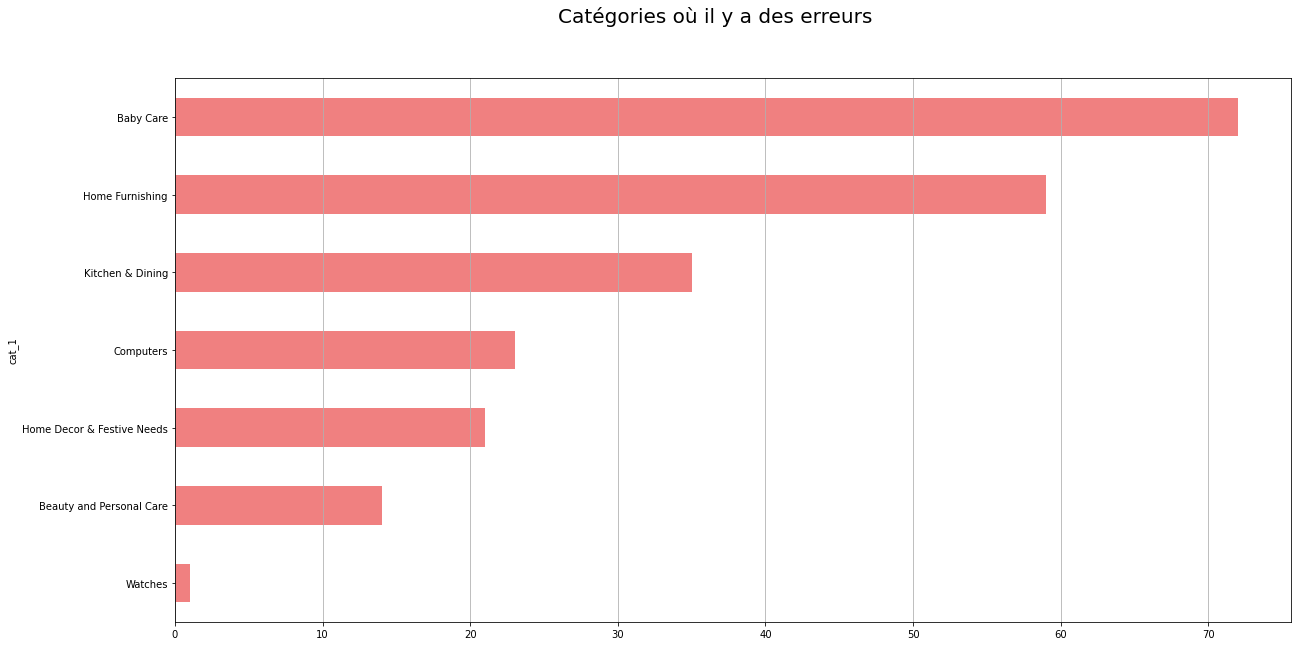

In [112]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Catégories où il y a des erreurs", fontsize=20)
df_errors["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, color='lightcoral',
        ax=ax).grid(axis='x')
plt.show()

In [86]:
df_errors[df_errors['cat_1']=='Baby Care'].sample(10);

cat_1  \
646   Baby Care   
1043  Baby Care   
672   Baby Care   
1004  Baby Care   
1044  Baby Care   
909   Baby Care   
773   Baby Care   
784   Baby Care   
968   Baby Care   
644   Baby Care   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       products_clean  \
646                                                                                                                                                                                                                                                                                                                                                                                                                       seal baby girl aline dress product _ specification value 1 dress key length value midiknee length key pattern value polka print key occasion value party key ideal value baby girl key sleeve value sleeveless key number content sale package value pack 1 key belt included value key fabric value synthetic key type value aline key neck value square neck value wash similar color use detergent color   
1043                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 999store medium paper sticker product _ specification key sale package value wall sticker key shape value rectangular key brand value 999store key type value paper key size number value 91 cm key number sticker value 1 key size value medium   
672                                                                                                                                                                                                                                                                                                                                                                                                                                                  indha craft cloth photo frame product _ specification key stand material value card board key frame material value cloth key backing value polyster bland key material value polythene key shape value rectangle key theme value brocade key color value pink key number photo value 1 key suitable photo size value 127 x 178 cm key height value 7 inch key width value 5 inch   
1004                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

#### Essai : modification des labels "catégories"

In [87]:
#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
candidate_labels = ['Home Furnishing', 'Baby', 'Watches',
       'Home Decor', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']

#Run classifier
predictions = []
for i in tqdm(range(0,1050)):
    preds = classifier(df_eval_products['products_clean'][i], candidate_labels, multi_class = True)
    pred_labels = preds["labels"][np.argmax(preds["scores"])]
    predictions.append(pred_labels)

#Put results into df    
df_eval_products['labels_zero_shot'] = predictions 

#Metrics ARI
categories_true = df_eval_products['cat_1']
categories_predict = df_eval_products['labels_zero_shot']
ari_USE_zero_shot  = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m


Adjusted Rand Index: 0.592


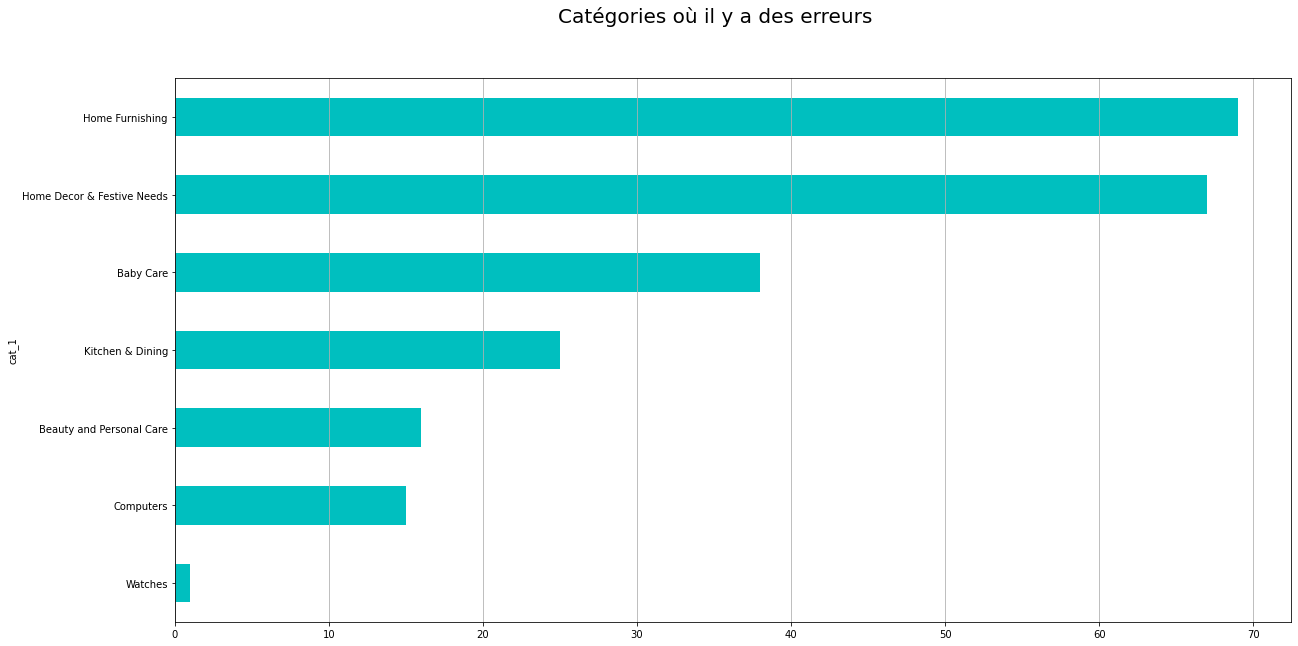

In [103]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.suptitle("Catégories où il y a des erreurs", fontsize=20)
df_errors_2["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, color='c',
        ax=ax).grid(axis='x')
plt.show()

In [108]:
#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
candidate_labels = ['Furnishing', 'Baby', 'Watches',
       'Decor', 'Kitchen',
       'Beauty', 'Computers']

#Run classifier
predictions = []
for i in tqdm(range(0,1050)):
    preds = classifier(df_eval_products['products_clean'][i], candidate_labels, multi_class = True)
    pred_labels = preds["labels"][np.argmax(preds["scores"])]
    predictions.append(pred_labels)

#Put results into df    
df_eval_products['labels_zero_shot'] = predictions 

#Metrics ARI
categories_true = df_eval_products['cat_1']
categories_predict = df_eval_products['labels_zero_shot']
ari_zero_shot_reduc  = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m


Adjusted Rand Index: 0.366


In [100]:
df_eval_products['labels_zero_shot'] = df_eval_products['labels_zero_shot'].replace('Baby', 'Baby Care')
df_eval_products['labels_zero_shot'] = df_eval_products['labels_zero_shot'].replace('Decor', 'Home Decor & Festive Needs')
df_eval_products['labels_zero_shot'] = df_eval_products['labels_zero_shot'].replace('Baby', 'Baby Care')
df_eval_products['labels_zero_shot'] = df_eval_products['labels_zero_shot'].replace('Home Decor', 'Home Decor & Festive Needs')

In [110]:
df_eval_products.head(100)

cat_1  \
0              Home Furnishing   
1                    Baby Care   
2                    Baby Care   
3              Home Furnishing   
4              Home Furnishing   
5                      Watches   
6                      Watches   
7                      Watches   
8                      Watches   
9                      Watches   
10                     Watches   
11                     Watches   
12                     Watches   
13                     Watches   
14                     Watches   
15                     Watches   
16                     Watches   
17                     Watches   
18                     Watches   
19                     Watches   
20                     Watches   
21                     Watches   
22                     Watches   
23                     Watches   
24                     Watches   
25                     Watches   
26                     Watches   
27                     Watches   
28                     Watches   
29                     Watches   
30                     Watches   
31                     Watches   
32                     Watches   
33             Home Furnishing   
34             Home Furnishing   
35             Home Furnishing   
36  Home Decor & Festive Needs   
37            Kitchen & Dining   
38            Kitchen & Dining   
39             Home Furnishing   
40                   Baby Care   
41             Home Furnishing   
42                   Baby Care   
43    Beauty and Personal Care   
44            Kitchen & Dining   
45            Kitchen & Dining   
46            Kitchen & Dining   
47                   Computers   
48            Kitchen & Dining   
49    Beauty and Personal Care   
50            Kitchen & Dining   
51                   Computers   
52            Kitchen & Dining   
53                   Computers   
54                   Computers   
55                   Computers   
56    Beauty and Personal Care   
57    Beauty and Personal Care   
58    Beauty and Personal Care   
59    Beauty and Personal Care   
60    Beauty and Personal Care   
61    Beauty and Personal Care   
62    Beauty and Personal Care   
63                   Baby Care   
64            Kitchen & Dining   
65            Kitchen & Dining   
66                   Baby Care   
67             Home Furnishing   
68            Kitchen & Dining   
69            Kitchen & Dining   
70            Kitchen & Dining   
71             Home Furnishing   
72            Kitchen & Dining   
73                   Baby Care   
74                   Baby Care   
75                   Baby Care   
76    Beauty and Personal Care   
77    Beauty and Personal Care   
78             Home Furnishing   
79                   Baby Care   
80  Home Decor & Festive Needs   
81  Home Decor & Festive Needs   
82                   Baby Care   
83                   Baby Care   
84  Home Decor & Festive Needs   
85  Home Decor & Festive Needs   
86            Kitchen & Dining   
87                   Computers   
88             Home Furnishing   
89  Home Decor & Festive Needs   
90  Home Decor & Festive Needs   
91  Home Decor & Festive Needs   
92  Home Decor & Festive Needs   
93  Home Decor & Festive Needs   
94  Home Decor & Festive Needs   
95  Home Decor & Festive Needs   
96  Home Decor & Festive Needs   
97  Home Decor & Festive Needs   
98    Beauty and Personal Care   
99    Beauty and Personal Care   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [102]:
df_errors_2 = df_eval_products[df_eval_products['cat_1'] != df_eval_products['labels_zero_shot']]
df_errors_2.shape

(231, 3)

### <span class="bg-success"> 4.4 Essai sur la colonne ensemble<span> 

In [44]:
df_eval_ensemble = df.filter(items = ['cat_1', 'ensemble_clean'])

In [45]:
pd.set_option('display.max_colwidth', 800)
df_eval_ensemble.head()

cat_1  \
0  Home Furnishing   
1        Baby Care   
2        Baby Care   
3  Home Furnishing   
4  Home Furnishing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ensemble_clean  
0  elegance elegance polyester multicolor abstract eyelet door curtain product _ specification key brand value elegance key designed value door key type value eyelet key model name value abstract polyester door curtain set 2 key model id value duster25 key color value multicolor key length value 213 cm key number content sale package value pack 2 key sale package value 2 curtain key material value polyester key feature elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price r 899 curtain enhances look interiorsthis curtain made 100 high quality polyester fabricit feature eyelet style stitch metal ringit make room environment romantic lovingthis curtain ant wrinkle anti shrinkage elegant ...  
1  sathiyas sathiyas cotton bath towel product _ specification key machine washable value yes key material value cotton key design value self design key brand value sathiyas key type value bath towel key gsm value 500 key model name value sathiyas cotton bath towel key ideal value men woman boy girl key model id value asvtwl322 key color value red yellow blue key size value mediam key length value 30 inch key width value 60 inch key number content sale package value 3 key sale package value 3 bath towel specification sathiyas cotton bath towel 3 bath towel red yellow blue bath towel feature machine washable yes material cotton design self design general brand sathiyas type bath towel gsm 500 model name sathiyas cotton bath towel ideal men woman boy girl model id asvtwl322 color red yellow...  
2  eurospa eurospa cotton terry face towel set product _ specification key material value cotton terry key design value shuvam key brand value eurospa key gsm value 360 key type value face towel set key model name value shuvam20pcftsetassorted key ideal value boy girl men woman key model id value shuvam20pcftsetassorted key size value small key color value assorted key weight value 350 g key length value 9 inch key width value 9 inch key number content sale package value 20 key sale package value 20 piece face towel set key feature eurospa cotton terry face towel set size small height 9 inch gsm 360eurospa cotton terry face towel set 20 piece face towel set assorted price r 299 eurospa brings exclusively designed 100 soft cotton towel export quality product soft texture take care skin giv...  
3  santosh royal fashion santosh royal fashion cotton printed king sized double bedsheet product _ specification key brand value santosh royal fashion key machine washable value yes key type value flat key material value cotton key model name value gold design royal cotton printed wedding gifted double bedsheet 2 pillow cover key model id value goldbedi38 key color value multicolor key size value king key fabric care value machine wash bleach key flat sheet width value 90 inch 230 cm key fitted sheet width value 228 cm key pillow cover width value 16 inch 43 cm key pillow cover length value 28 inch 72 cm key fitted sheet depth value 280 cm key fitted s

In [46]:
#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
candidate_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']

#Run classifier
predictions = []
for i in tqdm(range(0,1050)):
    preds = classifier(df_eval_ensemble['ensemble_clean'][i], candidate_labels, multi_class = True)
    pred_labels = preds["labels"][np.argmax(preds["scores"])]
    predictions.append(pred_labels)

#Put results into df    
df_eval_ensemble['labels_zero_shot'] = predictions 

#Metrics ARI
categories_true = df_eval_ensemble['cat_1']
categories_predict = df_eval_ensemble['labels_zero_shot']
ari_zero_shot_ensemble  = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m


Adjusted Rand Index: 0.408


### <span class="bg-success"> 4.5 Essai sur la colonne products + brand<span> 

In [47]:
df['products_brand'] = df['product_name'] + " " + df['product_specifications_clean']+ " " + df['brand']

In [50]:
#Define pipeline to use
classifier = pipeline('zero-shot-classification')

#Define input text and candidate labels
candidate_labels = ['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers']

#Run classifier
predictions = []
for i in tqdm(range(0,1050)):
    preds = classifier(df['products_brand'][i], candidate_labels, multi_class = True)
    pred_labels = preds["labels"][np.argmax(preds["scores"])]
    predictions.append(pred_labels)

#Put results into df    
df['labels_zero_shot'] = predictions 

#Metrics ARI
categories_true = df['cat_1']
categories_predict = df['labels_zero_shot']
ari_zero_shot_products_brand  = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m


Adjusted Rand Index: 0.547


### Résultats

In [173]:
resultats = pd.DataFrame({
    'Colonne' : ['product_name', 'products','ensemble'],
    'Nettoyage' : ['SANS', 'AVEC','AVEC'],
    'modèle' : ['ZERO-SHOT', 'ZERO-SHOT','ZERO-SHOT'],
    'ARI' : [ 0.39, 0.57, 0.41]})
resultats.set_index('modèle')

Colonne Nettoyage   ARI
modèle                                 
ZERO-SHOT  product_name      SANS  0.39
ZERO-SHOT      products      AVEC  0.57
ZERO-SHOT      ensemble      AVEC  0.41